In [1]:
import numpy as np
from fish.image.zds import ZDS
from fish.image.alignment import SYNreg
from fish.image.vol import dff
from skimage.io import imread
from skimage.transform import downscale_local_mean as downscale
from fish.util.plot import proj_fuse
import matplotlib.pyplot as plt
from dask.delayed import delayed
import flika as flk
flk.start_flika()

Starting flika


/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Starting flika inside IPython


In [3]:
def get_bbox(mask):
    from numpy import where
    lower = list(map(min, where(mask)))
    upper = list(map(lambda v: 1 + max(v), where(mask)))
    return tuple(slice(*bounds) for bounds in zip(lower, upper))

def get_aligned_roi(dset, roi):
    import numpy as np
    from scipy.ndimage.interpolation import shift
    regparams = np.load(dset.path.replace('raw', 'proc') + 'reg/regparams_affine.npy')[:,:-1,-1]
    raw = dset[:, roi[0], roi[1], roi[2]]
    # check dimensionality to see if we are doing 2D or 3D shift
    if raw.ndim == 4:
        regparams = np.hstack([np.zeros([regparams.shape[0],1]), regparams])
    shifted = np.zeros(raw.shape)
    for ind,t in enumerate(raw):
        shifted[ind] = shift(t, -regparams[ind], order=1)
        
    return shifted

In [4]:
ref_paths = ('/nrs/ahrens/davis/data/spim/proc/20180406/7dpf_ec43xcy171xcy331_opto_1_20180406_121139/',
            '/nrs/ahrens/davis/data/spim/proc/20180406/7dpf_ec43xcy171xcy331_opto_2_20180406_144001/')

meta = ZDS(ref_paths[0].replace('proc', 'raw')).metadata
axis_units = np.array((meta['z_step'] / .406, 1,1))
refs = [imread(f + '/reg/anat_reference.tif').astype('float32') for f in ref_paths]
ds_factors = (1,4,4)
refs_ds = [downscale(r, factors=ds_factors) for r in refs]

# Set transform parameters

In [29]:
%%time
level_iters_lin = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
level_iters_syn = [10, 10, 5]
# account for our spatial downsampling in axis units
axis_units_ds = axis_units * np.array(ds_factors)
syr = SYNreg(level_iters_lin, sigmas, factors, level_iters_syn)
syr.generate_warp_field(refs_ds[0], refs_ds[1], axis_units_ds, axis_units_ds)

Creating scale space from the moving image. Levels: 3. Sigma factor: 1.000000.
Creating scale space from the static image. Levels: 3. Sigma factor: 1.000000.
Optimizing level 2
Optimizing level 1
Optimizing level 0
CPU times: user 10min 16s, sys: 6.28 s, total: 10min 22s
Wall time: 10min 22s


In [30]:
from pickle import dump
with open(ref_paths[0] + 'reg/synreg.pickle', 'wb') as f:
    dump(syr.sdr_tx, f)

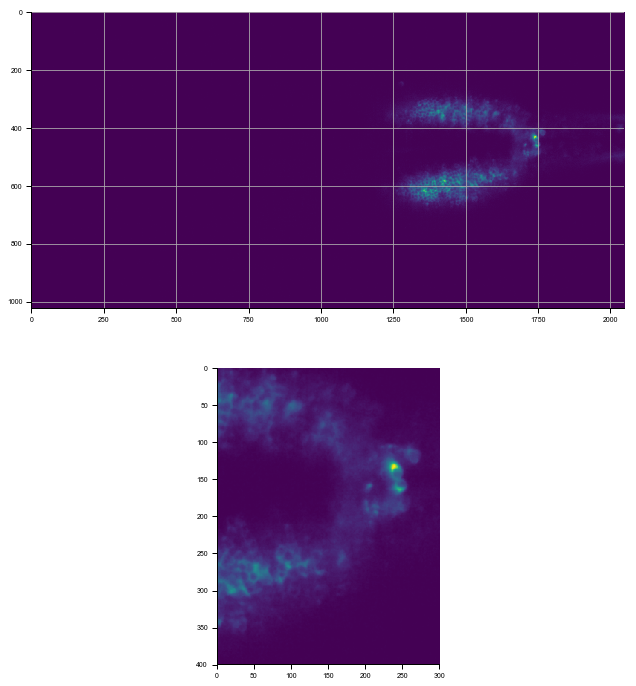

In [31]:
fig, axs = plt.subplots(figsize=(12,12), nrows=2)
z = 37
roi = slice(z, z+1), slice(300,700), slice(1500, 1800)
axs[0].imshow(refs[0][roi[0]].max(0))
axs[1].imshow(refs[0][roi].max(0))
axs[0].grid('on')

In [32]:
from numpy.linalg import inv
mask = np.zeros(refs[1].shape)
mask[roi] += 1
to_warp = mask
syr.sdr_tx.is_inverse = False
to_warp_g2w = np.eye(4)
to_warp_g2w[range(3), range(3)] = axis_units

mask_warped = syr.sdr_tx.transform(to_warp, image_world2grid=inv(to_warp_g2w), out_shape=to_warp.shape, out_grid2world=to_warp_g2w)

[None, None]

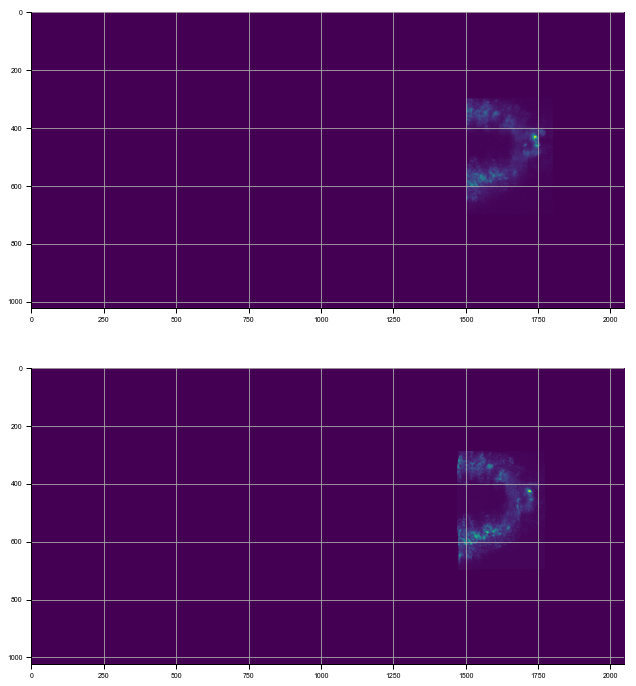

In [33]:
fig, axs = plt.subplots(nrows=2, figsize=(12,12))
axs[0].imshow((mask * refs[0]).max(0))
axs[1].imshow((mask_warped * refs[1]).max(0))
[ax.grid('on') for ax in axs]